In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from bs4 import BeautifulSoup
import string
import numpy as np
import os
import glob
from ast import literal_eval
import itertools

import warnings
warnings.simplefilter('ignore')

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

import wordcloud
from wordcloud import WordCloud, STOPWORDS
from textblob import Word
from collections import Counter

from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.models import load_model

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score

[nltk_data] Downloading package wordnet to /home/dnp5/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/dnp5/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/dnp5/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Modularize Pre-process function
stopwords_lstm = pd.read_csv('LSTM model/stopwords_lstm.csv')

def preprocess(text):
    
    stopwords = set(STOPWORDS)
    
    # Appending new airline related stop-words
    stopwords.update([str(i).lower() for i in stopwords_lstm.name]) 
    
    # Filter for mentions
    mentions_filter = re.compile(r'(?<=\@)(\w+)')
    
    # Filter for hash-tags
    hashtags_filter = re.compile(r'(?<=\#)(\w+)')
    
    # Filter for flights numbers
    flight_numbers = re.compile(r'(flt\d*)')
    
    # Finding all mentions
    all_mentions = mentions_filter.findall(text.lower())
    
    # Finding all hash-tags
    all_hashtag = hashtags_filter.findall(text.lower())
    
    # Finding all hash-tags
    all_flights = flight_numbers.findall(text.lower())
    
    word_lemmatize = WordNetLemmatizer()
    # Stemming 
    def stem_tokens(tokens, lemmatize):
        lemmatized = []
        for item in tokens:
            lemmatized.append(word_lemmatize.lemmatize(item,'v'))
        return lemmatized
    
    # De-emojify tweets to text
    def deEmojify(inputString):
        return inputString.encode('ascii', 'ignore').decode('ascii')
    
    text = deEmojify(text)
    soup = BeautifulSoup(text)
    text = soup.get_text()
    
    # Removing punctuation
    punc_text = [x.lower() for x in text if x not in string.punctuation]
    text = "".join(punc_text)
    
    # Tokenize words
    word_tokens = nltk.word_tokenize(text)
    
    # Keeping the words with length between 4 and 15
    filtered_tokens = [x for x in word_tokens if len(x)>2 and len(x)<15]
    
    # Filter tokens
    tokens = stem_tokens(filtered_tokens, word_lemmatize)
    all_tokens = [i for i in tokens if (i not in stopwords) and (i not in all_mentions) 
                  and (i not in all_hashtag) and (i not in all_flights) and (not i.isdigit())]
    
    return all_tokens

In [3]:
model = load_model("LSTM model/model.h5")
model.load_weights('LSTM model/model_weights.h5') 
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

f = open('LSTM model/X_train_max_length.txt', "r")
max_length = int(f.read())

df_vals = pd.read_csv('LSTM model/train_text_vals.csv',converters={'text_tokenized': literal_eval})
tokenizer = Tokenizer(num_words=500, split=' ')
tokenizer.fit_on_texts(df_vals['text_tokenized'].values)

2022-04-08 13:40:49.104313: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 13:40:49.126093: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 13:40:49.126325: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-08 13:40:49.126894: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [4]:
from sklearn.utils import shuffle
import pandas as pd
df = pd.read_csv('final_train_df.csv',encoding = "ISO-8859-1")
df = df.drop(['Unnamed: 0'],axis=1)
df = shuffle(df)
df.head()

,tweet_id,username,text,airline_name,airline_sentiment,tweet_location
149,5.695960e+17,khartline,.@VirginAmerica I don't understand why you nee...,Virgin America,negative,Las Vegas
1495,5.696990e+17,scottecrouch,@united we've been waiting 45 min for a gate a...,United,negative,"New York & Washington, D.C."
5866,5.685370e+17,PLLMyObsessionn,@SouthwestAir yes please,Southwest,neutral,We know all so follow -A
11611,5.678810e+17,wcpojesse,@USAirways thanks! It's hectic for everyone bu...,US Airways,positive,Cincinnati
14488,5.696080e+17,igclp,@AmericanAir I would like a refund for this fl...,American,negative,NaN


In [5]:
df['processed_tweet'] = df['text'].apply(lambda x: preprocess(x)) 

In [6]:
df.head()

,tweet_id,username,text,airline_name,airline_sentiment,tweet_location,processed_tweet
149,5.695960e+17,khartline,.@VirginAmerica I don't understand why you nee...,Virgin America,negative,Las Vegas,"[dont, understand, need, give, answer, damage,..."
1495,5.696990e+17,scottecrouch,@united we've been waiting 45 min for a gate a...,United,negative,"New York & Washington, D.C.","[unite, weve, wait, min, gate, sfo, yet, many,..."
5866,5.685370e+17,PLLMyObsessionn,@SouthwestAir yes please,Southwest,neutral,We know all so follow -A,"[yes, please]"
11611,5.678810e+17,wcpojesse,@USAirways thanks! It's hectic for everyone bu...,US Airways,positive,Cincinnati,"[thank, hectic, everyone, action, dont, repres..."
14488,5.696080e+17,igclp,@AmericanAir I would like a refund for this fl...,American,negative,NaN,"[refund, delay, time, feel, youre, make, fun]"


In [7]:
X = df.drop(['airline_sentiment'],axis=1)
y = df['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [8]:
def decode_prediction(prediction):
    if prediction == 0:
        return "Negative"
    elif prediction == 1:
        return "Neutral"
    else:
        return "Positive"

def predict_sentiment(text):
    text = preprocess(text)
    text = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen = max_length, dtype='float64')

    prediction = model.predict([text])
    result = np.where(prediction[0] == np.amax(prediction[0]))

    return decode_prediction(result[0])

In [9]:
y_pred = X_test['text'].apply(lambda x: predict_sentiment(x)) 

In [10]:
y_pred = y_pred.map({'Negative':0,'Neutral':1,'Positive':2})

In [11]:
y_test = y_test.map({'negative':0,'neutral':1,'positive':2})

In [12]:
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

array([[1371,  407,  200],
       [ 128,  334,  158],
       [  58,   56,  383]])

In [13]:
def plot_confusion_matrix(cm, classes):

    tick_marks = np.arange(len(classes))
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j]), horizontalalignment="center",
                 color="white" if cm[i, j] > (cm.max() / 2.0) else "black")
    
    plt.imshow(cm, cmap = plt.cm.YlGnBu)
    plt.colorbar()
    plt.title('Confusion matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    plt.tight_layout()

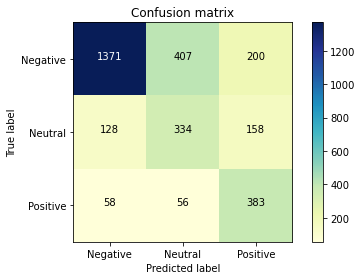

In [14]:
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Neutral', 'Positive'])